In [301]:
# import numpy as np
# import pandas as pd
# import plotly.express as px
# import plotly.graph_objects as go
# import streamlit as st

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import yfinance as yf
import datetime as dt

import streamlit as st


In [280]:
def read_data(tickers, start_date, end_date=dt.datetime.now().date()):
    return yf.download(tickers, start=start_date, end=end_date)['Adj Close']

def get_cols_by_substring(df, substring):
    return df.loc[:,[substring in i for i in df.columns]]

def run_ma_analysis(tickers, ma_params, breach_limit_alert, data):

    # Extract the tickers from the data
    tickers = data.columns.tolist()  # Assuming tickers are the column names of `data`

    # Create a main dictionary to store results for each ticker
    results = {}

    # Calculate moving averages and other metrics for each ticker
    for ticker in tickers:
        # Create an empty DataFrame for the current ticker
        ticker_df = pd.DataFrame(index=data.index)

        # Store the closing prices for the ticker
        ticker_df["Ticker"] = ticker
        ticker_df["Price"] = data[ticker]

        # Create an empty DataFrame to store moving averages
        ma_df = pd.DataFrame(index=data.index)

        # Initialize a breach count for the ticker
        breach_count = 0

        # Calculate moving averages using cumulative sum for each window
        for window, threshold in ma_params.items():
            # Compute cumulative sum for the ticker
            cumsum = data[ticker].cumsum()

            # Calculate moving average using the cumulative sum method
            ma_df[f"MA{window}"] = (cumsum - cumsum.shift(window)).div(window)

            # Correct for the first `window` days where rolling can't happen (copy first values)
            ma_df.loc[:data.index[window-1], f"MA{window}"] = data[ticker].iloc[:window].mean()

            # Add the moving average prices to the ticker DataFrame
            ticker_df[f"MA{window}"] = ma_df[f"MA{window}"]

            # Calculate delta as a percentage of the price
            delta_pct = ((data[ticker] - ma_df[f"MA{window}"]) / ma_df[f"MA{window}"]) * 100
            ticker_df[f"Delta_MA{window}_Pct"] = delta_pct

            # Compare the delta percentage with the threshold to check for a breach
            ticker_df[f"MA{window}_Breach"] = np.where(delta_pct >= threshold, 1,
                np.where(delta_pct <= -threshold, -1, 0))  # 1 for upper breach, -1 for lower breach


        # Calculate the total number of breaches for the ticker
        ticker_df['Total_Breach'] = ticker_df.filter(like='_Breach').sum(axis=1)  # Count total breaches per day
        ticker_df['Signal'] = np.where(ticker_df['Total_Breach'] >= breach_limit_alert, 'SELL',np.where(ticker_df['Total_Breach'] <= -breach_limit_alert, 'BUY',''))

        # Add the ticker DataFrame to the results dictionary
        results[ticker] = ticker_df

        results_recent = pd.DataFrame()

        for ticker in results:
            results_recent = pd.concat([results_recent, results[ticker].tail(1)])

    return results, results_recent[['Ticker', 'Price', 'Total_Breach', 'Signal']]

def plot_signals(results, ticker):
    plot_df = results[ticker]

    # Plotting
    plt.figure(figsize=(12, 6))

    # Plotting Price with lines only
    plt.plot(plot_df.index, plot_df['Price'], label='Price', color='blue')

    # Initialize flags for previous breaches
    previous_positive_breach = False
    previous_negative_breach = False

    # Highlighting breach days
    for i in range(len(plot_df)):
        date = plot_df.index[i]
        breach = plot_df['Total_Breach'].iloc[i]

        # Handling +ve signals breaches (> 3) : BUY
        if breach < -4:
            if previous_positive_breach:  # Check if the previous day also had a positive breach
                plt.scatter(date, plot_df['Price'].iloc[i], color='green', zorder=5, marker='o')  # Circle for second breach
            else:
                plt.scatter(date, plot_df['Price'].iloc[i], color='green', zorder=5, marker='x')  # 'x' for first breach
            previous_positive_breach = True  # Set flag for positive breach
            previous_negative_breach = False  # Reset negative breach flag

        # Handling -ve breaches (< -3) : SELL
        elif breach > 4:
            if previous_negative_breach:  # Check if the previous day also had a negative breach
                plt.scatter(date, plot_df['Price'].iloc[i], color='red', zorder=5, marker='o')  # Circle for second breach
            else:
                plt.scatter(date, plot_df['Price'].iloc[i], color='red', zorder=5, marker='x')  # 'x' for first breach
            previous_negative_breach = True  # Set flag for negative breach
            previous_positive_breach = False  # Reset positive breach flag
        else:
            # Reset flags if there's no breach
            previous_positive_breach = False
            previous_negative_breach = False

    # Adding titles and labels
    plt.title(f'{ticker} Signals', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Price', fontsize=14)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()
    plt.tight_layout()

    # Show the plot
    plt.show()



/var/folders/bv/5z8qsff92ynb2m11_zzl_j7r0000gn/T/ipykernel_52607/115777141.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_results["Total_Breach_ABS"] = final_results["Total_Breach"].abs()


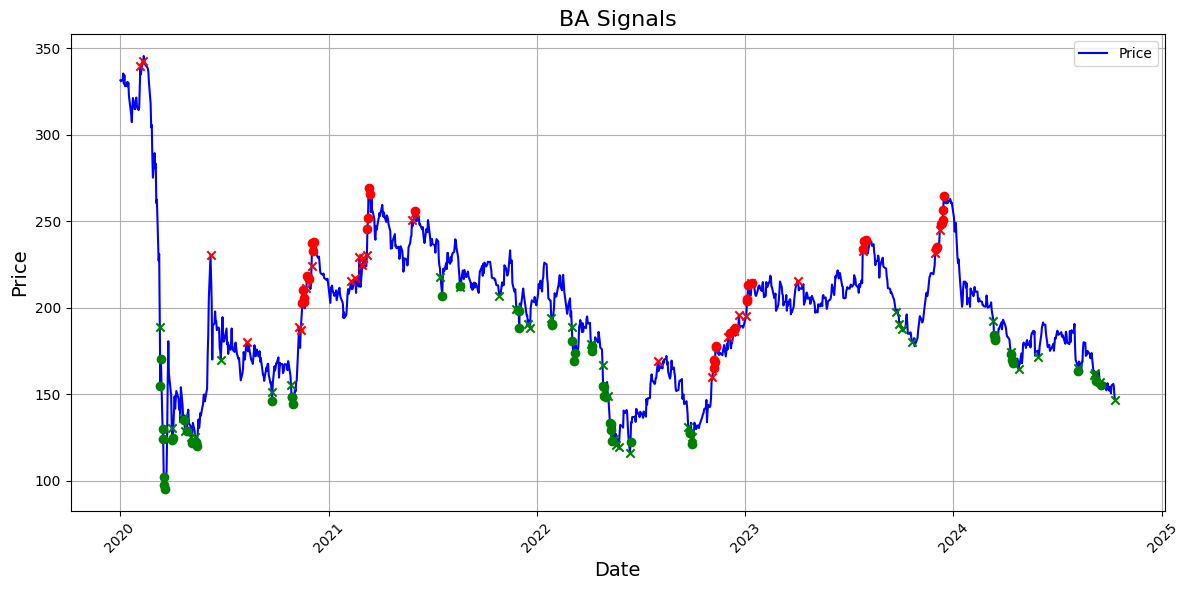

,Ticker,Price,Total_Breach,Signal,Total_Breach_ABS
Date,,,,,
2024-10-10,ARM,149.330002,4,SELL,4
2024-10-10,AVGO,185.690002,5,SELL,5
2024-10-10,BA,146.619995,-5,BUY,5
2024-10-10,CPRT,55.599998,4,SELL,4
2024-10-10,CRWD,314.920013,4,SELL,4
2024-10-10,CVS,66.849998,4,SELL,4
2024-10-10,DDOG,130.089996,5,SELL,5
2024-10-10,FTNT,82.480003,5,SELL,5
2024-10-10,IBM,233.020004,4,SELL,4


In [313]:
ma_params = {
    5: 1.75,    # 2.5% for the 5-day MA
    10: 2.75,   # 3.0% for the 10-day MA
    15: 3.5,   # 3.5% for the 15-day MA
    20: 4,    # 4.0% for the 20-day MA
    100: 8.0    # 4.0% for the 20-day MA
}
breach_limit_alert = 4
tickers = ['AAPL', 'NVDA', 'MSFT', 'GOOG', 'GOOGL', 'AMZN', 'META', 'AVGO', 'TSLA', 'COST', 'ASML', 'NFLX', 'AMD', 'TMUS', 'AZN', 'PEP', 'LIN', 'ADBE', 'CSCO', 'PDD', 'QCOM', 'TXN', 'INTU', 'AMGN', 'ISRG', 'AMAT', 'CMCSA', 'ARM', 'BKNG', 'HON', 'VRTX', 'PANW', 'MU', 'ADP', 'ADI', 'REGN', 'KLAC', 'SBUX', 'LRCX', 'GILD', 'MELI', 'INTC', 'MDLZ', 'ABNB', 'CTAS', 'CEG', 'SNPS', 'PYPL', 'CRWD', 'CDNS', 'MAR', 'ORLY', 'CSX', 'WDAY', 'FTNT', 'MRVL', 'NXPI', 'ADSK', 'DASH', 'ROP', 'FANG', 'TTD', 'PCAR', 'CPRT', 'AEP', 'PAYX', 'MNST', 'KDP', 'TEAM', 'CHTR', 'ROST', 'DDOG', 'KHC', 'ODFL', 'MCHP', 'GEHC', 'FAST', 'EXC', 'IDXX', 'VRSK', 'EA', 'BKR', 'CTSH', 'CCEP', 'XEL', 'LULU', 'CSGP', 'ON', 'ZS', 'CDW', 'ANSS', 'DXCM', 'BIIB', 'TTWO', 'ILMN', 'GFS', 'MRNA', 'MDB', 'WBD', 'DLTR', 'WBA', 'LLY', 'WMT', 'JPM', 'BRK-B', 'UNH', 'ORCL', 'XOM', 'V', 'MA', 'HD', 'PG', 'JNJ', 'ABBV', 'BAC', 'KO', 'MRK', 'CVX', 'ACN', 'TMO', 'MCD', 'IBM', 'ABT', 'WFC', 'AXP', 'CAT', 'PM', 'VZ', 'MS', 'PFE', 'DIS', 'RTX', 'GS', 'T', 'LOW', 'UNP', 'LMT', 'COP', 'C', 'MDT', 'BMY', 'NKE', 'UPS', 'SO', 'BA', 'MO', 'CVS', 'CL', 'GD', 'MMM', 'TGT', 'USB', 'FCX', 'FDX', 'EMR', 'WMB', 'MET', 'COF', 'NSC', 'SPG', 'BK', 'GM', 'AIG', 'F', 'DOW', 'HPQ', 'EBAY', 'HAL', 'DVN', 'BAX']

# data = read_data(tickers=tickers, start_date=dt.date(2020,1,1))
# results, results_summarised = run_ma_analysis(tickers=tickers, ma_params=ma_params, breach_limit_alert=breach_limit_alert, data=data)

# Write results to file.
# final_results = results_summarised.loc[results_summarised['Signal']!=""]
# final_results["Total_Breach_ABS"] = final_results["Total_Breach"].abs()
# final_results.to_csv("ma_results/ma_index_tickers_" + dt.datetime.today().strftime('%Y-%m-%d') + ".csv")


plot_signals(results=results, ticker="BA")

final_results

In [255]:
results_recent_clean

Empty DataFrame
Columns: []
Index: []


,Ticker,Price,Total_Breach,Signal
Date,,,,
2024-10-09,AMZN,185.169998,0,
2024-10-09,JPM,213.419998,1,
2024-10-09,META,590.510010,2,
2024-10-09,NVDA,132.649994,5,SELL
2024-10-09,OR.PA,390.000000,0,


In [142]:
get_cols_by_substring(results["AMZN"], "MA").mean()

MA5               177.645278
Delta_MA5_Pct       0.230520
MA5_Breach          0.046392
MA10              177.278814
Delta_MA10_Pct      0.454917
MA10_Breach         0.072165
MA15              176.849330
Delta_MA15_Pct      0.711678
MA15_Breach         0.077320
MA20              176.513286
Delta_MA20_Pct      0.907956
MA20_Breach         0.072165
dtype: float64

In [149]:
get_cols_by_substring(results["AMZN"], "MA").quantile(.9)

MA5               190.187001
Delta_MA5_Pct       2.288429
MA5_Breach          0.000000
MA10              189.679402
Delta_MA10_Pct      3.832175
MA10_Breach         1.000000
MA15              188.494402
Delta_MA15_Pct      4.708526
MA15_Breach         1.000000
MA20              188.772001
Delta_MA20_Pct      4.967004
MA20_Breach         1.000000
Name: 0.9, dtype: float64

In [166]:
get_cols_by_substring(results["AMZN"], "MA").quantile(.9).round(2).to_dict()

{'MA5': 190.19,
 'Delta_MA5_Pct': 2.29,
 'MA5_Breach': 0.0,
 'MA10': 189.68,
 'Delta_MA10_Pct': 3.83,
 'MA10_Breach': 1.0,
 'MA15': 188.49,
 'Delta_MA15_Pct': 4.71,
 'MA15_Breach': 1.0,
 'MA20': 188.77,
 'Delta_MA20_Pct': 4.97,
 'MA20_Breach': 1.0}

# Dashboard: Presenting the Results

In [ ]:
# print(final_results)

def run_dashboard():
    st.set_page_config(layout="wide")
    st.title("Macro Indicators - UK")

    st.subheader('Index Signals across SP100 and Nasdaq 100')

    with st.expander("Data"):
        st.dataframe(
            final_results.
        )



In [317]:
final_results.sort_values(["Signal", "Total_Breach_ABS"], ascending=[True, False])

,Ticker,Price,Total_Breach,Signal,Total_Breach_ABS
Date,,,,,
2024-10-10,BA,146.619995,-5,BUY,5
2024-10-10,MRNA,56.830002,-5,BUY,5
2024-10-10,WBD,7.540000,-4,BUY,4
2024-10-10,AVGO,185.690002,5,SELL,5
2024-10-10,DDOG,130.089996,5,SELL,5
2024-10-10,FTNT,82.480003,5,SELL,5
2024-10-10,ILMN,143.759995,5,SELL,5
2024-10-10,MDB,292.690002,5,SELL,5
2024-10-10,NVDA,134.809998,5,SELL,5


In [ ]:
final_results.sort_values(["Signal", "Total_Breach_ABS"], ascending=[True, False])